# Homework 5: Part 2

## Welcome Back

Now that you've preprocessed the data using Spark and Natural Language processing, found topics in sentences using LDA, and created some sentiment analysis using Naive Bayes we continue our analysis by looking at the probabilities from our model. 

If you used the AWS cluster or Vagrant for Spark make sure to shut down your cluster and `halt` Vagrant.

# Table of Contents
* [Homework 5: Part 2](#Homework-5:-Part-2)
	* [Welcome Back](#Welcome-Back)
		* [Create dataframes for Topic 0 and Topic 1](#Create-dataframes-for-Topic-0-and-Topic-1)
	* [5. Playing with probability](#5.-Playing-with-probability)
		* [Probabilities per review and topic](#Probabilities-per-review-and-topic)
			* [5.1 What are the probabilities of classification for the two LDA topics?](#5.1-What-are-the-probabilities-of-classification-for-the-two-LDA-topics?)
		* [A single example.](#A-single-example.)
			* [5.2 Plots of probability vs star rating](#5.2-Plots-of-probability-vs-star-rating)
		* [A Bayesian analysis of sentence probabilities](#A-Bayesian-analysis-of-sentence-probabilities)
		* [Assuming Normality](#Assuming-Normality)
			* [Posterior distribution](#Posterior-distribution)
		* [Empirical Bayes](#Empirical-Bayes)
			* [Marginal Distribution of data](#Marginal-Distribution-of-data)
		* [Estimating $\mu$](#Estimating-$\mu$)
			* [5.3 Write a function to calculate the overall mean of all reviews for a given restaurant](#5.3-Write-a-function-to-calculate-the-overall-mean-of-all-reviews-for-a-given-restaurant)
			* [A better estimate of $\mu$.](#A-better-estimate-of-$\mu$.)
		* [Compute the estimated $\tau^2$](#Compute-the-estimated-$\tau^2$)
			* [Simple initial estimate of $\tau^2$](#Simple-initial-estimate-of-$\tau^2$)
		* [Iterating Once More](#Iterating-Once-More)
			* [Fisher Weighting (again)](#Fisher-Weighting-%28again%29)
			* [Nearly There!](#Nearly-There!)
			* [Some considerations with this zero-finding (optimization)](#Some-considerations-with-this-zero-finding-%28optimization%29)
			* [Calculate an updated, Fisher weighted mean.](#Calculate-an-updated,-Fisher-weighted-mean.)
		* [Back to the posterior](#Back-to-the-posterior)
		* [Probabilities and shrinkage](#Probabilities-and-shrinkage)
			* [5.4 Make a shrinkage plot](#5.4-Make-a-shrinkage-plot)
			* [Shrinkage plots on individual probabilities](#Shrinkage-plots-on-individual-probabilities)
			* [5.5 Extract data into the variable `data2` and make a shrinkage plot for Topic 1.](#5.5-Extract-data-into-the-variable-data2-and-make-a-shrinkage-plot-for-Topic-1.)
			* [5.6 Create probability shrinkage plots.](#5.6-Create-probability-shrinkage-plots.)
			* [5.7 How would one evaluate these probabilities?](#5.7-How-would-one-evaluate-these-probabilities?)


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

### Create dataframes for Topic 0 and Topic 1

We split the dataframes based on the `topic` to create two dataframes based on Topic 0 and Topic 1.

In [2]:
dftouse=pd.read_csv("dftouse.csv")
dftouse.head()

,review_id,topic,rid,count,max,mean,min,stars,uavg,var
0,---sV8KdwfBoDw38KW_WnQ,0,VgLiSW1iGkpzIEXOgvUBEw,5,0.689383,0.558430,0.312919,3,3.285714,0.024112
1,---sV8KdwfBoDw38KW_WnQ,1,VgLiSW1iGkpzIEXOgvUBEw,5,0.816901,0.554300,0.211441,3,3.285714,0.050309
2,--0MzHNy7MVBRvZCOAeRPg,0,4gLecengX1JeGILm7DwU3w,3,0.746711,0.574416,0.360240,5,3.829268,0.038655
3,--0MzHNy7MVBRvZCOAeRPg,1,4gLecengX1JeGILm7DwU3w,6,0.848065,0.657755,0.476156,5,3.829268,0.014583
4,--2NT40xmHh9oBLumzdjhA,0,4ZZab5hinFzHtj3sE8vQWg,5,0.764218,0.601008,0.337710,2,4.181818,0.026742


In [3]:
c0df=dftouse[dftouse.topic==0]
c1df=dftouse[dftouse.topic==1]

In [4]:
c0df.head()

,review_id,topic,rid,count,max,mean,min,stars,uavg,var
0,---sV8KdwfBoDw38KW_WnQ,0,VgLiSW1iGkpzIEXOgvUBEw,5,0.689383,0.558430,0.312919,3,3.285714,0.024112
2,--0MzHNy7MVBRvZCOAeRPg,0,4gLecengX1JeGILm7DwU3w,3,0.746711,0.574416,0.360240,5,3.829268,0.038655
4,--2NT40xmHh9oBLumzdjhA,0,4ZZab5hinFzHtj3sE8vQWg,5,0.764218,0.601008,0.337710,2,4.181818,0.026742
6,--2Ylq1M_Toj6e0hy_C2XA,0,e9er1p-8RMyRa9IKUzKE-w,4,0.743135,0.613059,0.539191,4,3.500000,0.008469
8,--3QRshg8GhfimzyGWkcAQ,0,T2zItRCqolfzSZR2Io0OZg,2,0.758943,0.756603,0.754264,5,3.250000,0.000011


## 5. Playing with probability

Now that we have "average" probabilities with standard deviations set up on a per topic and per review basis, we can see what inferences we can set up with these probabilities.

For each of the LDA topics, and each restaurant, here we don't have a simple probability, but rather, a mean probability and a variance on this probability, 

What are these numbers?

### Probabilities per review and topic

**For the following discussion, let's limit the scope to one restaurant and one topic**. We will be writing the code to calculate these quantities for each restaurant and topic, but the math will all be done for one for simplicity.

This restaurant will have a number of reviews ($i = 1, ..., r$), each review will have a number of sentences ($n_i$) about food. 

Each such sentence will have a probability of being positive $p_{ij}$, i.e. the probability that the $j^{th}$ sentence in the $i^{th}$ review (group) is positive.

In order to do an analysis we need to make some distributional assumptions about the data we're observing. It's hard to make any distributional assumptions about the $p_{ij}$ themselves, they take values between 0 and 1, it would be possible to assume a Beta distribution. 

But in our case, because we're interested in the average "positivity" of the sentences for each review we'll be looking at 

$$
\bar{y}_{i} =  \frac{1}{n_i} \sum_{j = 1}^{n_i}p_{ij}
$$


Let's assume that this average is **normally distributed** for each review ($i = 1, ..., r$). This is a major assumption, we must assume that we have a sufficient number of sentences $n_i$ for each review $i = 1, ..., r$. This assumption is not always justified by our data, but we will use it anyways.

At this point you might be doing a double take, saying the average is a number we just calculated. But note our assumptions, common to all statistical modeling.

The $p_{ij}$ are statistical quantities to be estimated. Here the values we calculated for them are *estimates*. Similarly, the mean of the estimates is also a sample estimate. Another sample for the same-review, same restaurant (a bootstrap sample, if you like) would give slightly different estimates. So there is a quantity $\bar{y}_{i}$ thats normally distributed and whose mean can be estimated by the sample mean we calculated.

What about the variance of this normal. Its the variance of the sampling distribution of the means. So its the estimated variance we calculated divided by the number of sentences for each review and topic.

This can be a bit confusing to understand. But it might help to assume that the quantities $p_{ij}$ are normally distributed with some mean and variance parameter, estimated by the review-topic mean and variance. Then we are just trying to get the sampling distribution of the mean. But we dont have to make this assumption.

Notice what this also says about the range of possible values for $\bar{y}_{i}$: we know by construction that it's between 0 and 1, however this modeling assumption says that it can take any values without restriction. Generally speaking this is a also bad assumption to make, but we'll see that it gives us tremendous leverage in terms of pooling information across reviews.

#### 5.1 What are the probabilities of classification for the two LDA topics?

Ok, so then assume a _Gaussian distribution_ of probability means with parameter estimates the review means and variances. Now, using the CDF of the Gaussian like we did in _Homework 2_, we can calculate the _fraction of positive classifications_ for class 0 and class 1 (Use 0.5 as the threshold).

First we define a function `prob` which takes as arguments a mean and a variance and returns the probability that a sample is positive. We will be using this function later as well.

Notice we need to divide the variance by the count `num` in the formula below to convert from the in-sample variance to the variance of the sample mean. Put another way as compared to the paragraph above, the reason for this is that what we are interested in estimating here is not the average probability of a sentence, for say, topic 0 being positive, but rather the average probability of topic 0 in a review being positive.

In [5]:
from scipy.special import erf
prob= lambda mu, vari, num: .5 * (1 - erf((0.5- mu) / np.sqrt(2 * vari/float(num))))

Now write code to report the fraction of reviews that are positive on each of the LDA classes

In [6]:
#your code here
print "For class 0"
c0po=c0df.apply(lambda row: prob(row['mean'], row['var'], row['count']), axis=1) >= 0.5
print np.mean(c0po)
print "For class 1"
c1po=c1df.apply(lambda row: prob(row['mean'], row['var'], row['count']), axis=1) >= 0.5
print np.mean(c1po)


For class 0
0.851975168612
For class 1
0.847180716312


Explain why these answers could be very different from the `priorp` and `priorn` we calculated earlier?. 

*your answer here*

Because the probabilities are based on the text analysis alone they may not have anything to do with the star rating. This is an entirely seperate analysis meant to classify the sentences into topics. `Priorp` and `priorn` are both summaries of the star ratings alone.


### A single example.

For the business id 'T2zItRCqolfzSZR2Io0OZg',let us see what our class0 and class1 probability distributions look like

In [7]:
c0df[c0df.rid=='T2zItRCqolfzSZR2Io0OZg']

,review_id,topic,rid,count,max,mean,min,stars,uavg,var
8,--3QRshg8GhfimzyGWkcAQ,0,T2zItRCqolfzSZR2Io0OZg,2,0.758943,0.756603,0.754264,5,3.250000,0.000011
19430,7Mg3i3KvbFF5eSoRYoc48w,0,T2zItRCqolfzSZR2Io0OZg,1,0.751882,0.751882,0.751882,4,4.428571,0.000000
64615,QxEQ5q7R0SWGL31niiETyg,0,T2zItRCqolfzSZR2Io0OZg,6,0.750458,0.667189,0.568503,4,3.463918,0.005438
77013,WNDMIxVnfMI7wq7Lc9mi4Q,0,T2zItRCqolfzSZR2Io0OZg,2,0.876106,0.837516,0.798925,4,3.000000,0.002978
94050,cmSaTa-eyoEAUSGThp5A4g,0,T2zItRCqolfzSZR2Io0OZg,3,0.838688,0.687485,0.611883,5,5.000000,0.017147
134516,uBLMbE-Pa0IFx-xghripIQ,0,T2zItRCqolfzSZR2Io0OZg,2,0.810383,0.630500,0.450617,2,2.000000,0.064716
141202,x72wx4MCuUV_-St6q2eROg,0,T2zItRCqolfzSZR2Io0OZg,3,0.890353,0.801496,0.749916,5,3.403846,0.005973


In [8]:
c1df[c1df.rid=='T2zItRCqolfzSZR2Io0OZg']

,review_id,topic,rid,count,max,mean,min,stars,uavg,var
9,--3QRshg8GhfimzyGWkcAQ,1,T2zItRCqolfzSZR2Io0OZg,1,0.888077,0.888077,0.888077,5,3.250000,0.000000
19431,7Mg3i3KvbFF5eSoRYoc48w,1,T2zItRCqolfzSZR2Io0OZg,4,0.746711,0.567850,0.294765,4,4.428571,0.041787
26393,AO3QETuRVA_e5Nn6VFOKUQ,1,T2zItRCqolfzSZR2Io0OZg,2,0.628768,0.626272,0.623777,5,5.000000,0.000012
64616,QxEQ5q7R0SWGL31niiETyg,1,T2zItRCqolfzSZR2Io0OZg,5,0.692375,0.626948,0.605831,4,3.463918,0.001345
94051,cmSaTa-eyoEAUSGThp5A4g,1,T2zItRCqolfzSZR2Io0OZg,2,0.844971,0.838555,0.832139,5,5.000000,0.000082
141203,x72wx4MCuUV_-St6q2eROg,1,T2zItRCqolfzSZR2Io0OZg,1,0.758943,0.758943,0.758943,5,3.403846,0.000000


#### 5.2 Plots of probability vs star rating

For both class 0 and class 1 , we plot the star rating against the probability means with a 1-sigma error bar. Make the plots **side-by-side** for easier comparison and jitter the vertical position (the star rating) with a bit of random noise for clarity. Make sure the x-range of the plot is from 0 to 1. Use a dot for the mean, changing the point size using the count of the number of sentences used in the review. (you will need to overlay a `plt.scatter` for this). Once again, dont forget to divide the probability variance by the count. If the variance is 0, set it to 4. This happens because there was not enough data to estimate the probabilities well so we should assume we are very diffuse in its knowledge

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


(0, 1)

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


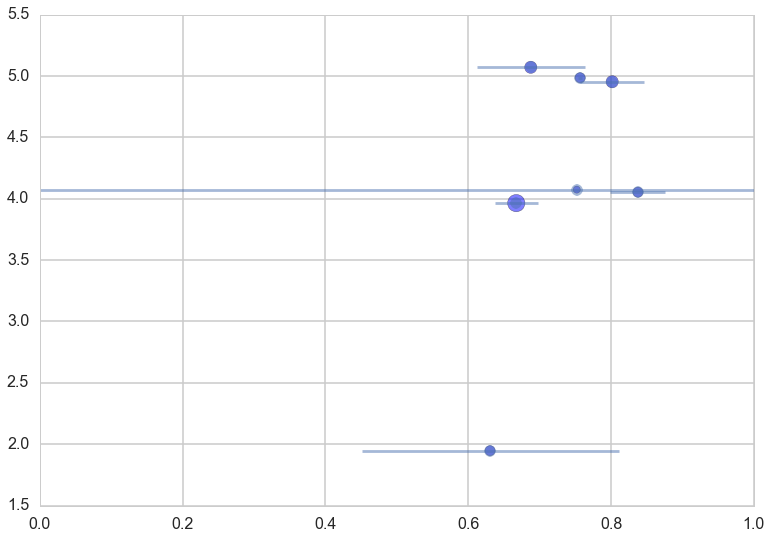

In [9]:
#your code here
stars=c0df[c0df.rid=='T2zItRCqolfzSZR2Io0OZg']['stars']
pmean=c0df[c0df.rid=='T2zItRCqolfzSZR2Io0OZg']['mean']
pvar=c0df[c0df.rid=='T2zItRCqolfzSZR2Io0OZg']['var']
size=c0df[c0df.rid=='T2zItRCqolfzSZR2Io0OZg']['count']
pvar=pvar/size
pvar=[p if p!=0 else 4 for p in pvar]
noise=0.1*np.random.randn(stars.shape[0])
plt.errorbar(pmean, stars+noise, xerr=np.sqrt(pvar), fmt='o', alpha=0.5)
plt.scatter(pmean, stars+noise,  marker="o", s=50*size, alpha=0.5)

plt.xlim([0,1])

(0, 1)

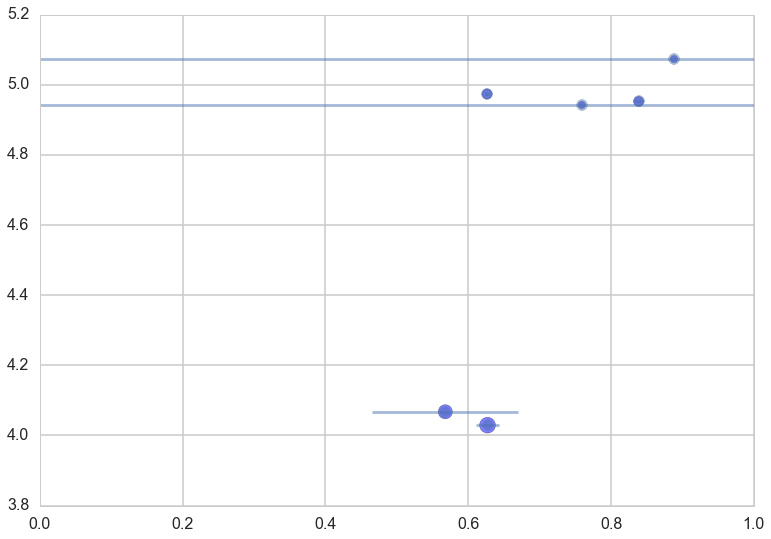

In [10]:
#your code here
stars=c1df[c1df.rid=='T2zItRCqolfzSZR2Io0OZg']['stars']
pmean=c1df[c1df.rid=='T2zItRCqolfzSZR2Io0OZg']['mean']
pvar=c1df[c1df.rid=='T2zItRCqolfzSZR2Io0OZg']['var']
size=c1df[c1df.rid=='T2zItRCqolfzSZR2Io0OZg']['count']
pvar=pvar/size
pvar=[p if p!=0 else 4 for p in pvar]
noise=0.1*np.random.randn(stars.shape[0])
plt.errorbar(pmean, stars+noise, xerr=np.sqrt(pvar), fmt='o', alpha=0.5)
plt.scatter(pmean, stars+noise,  marker="o", s=50*size, alpha=0.5)

plt.xlim([0,1])

Interpret the diagrams. Which probabilities would you believe more? Why?

*your answer here*

From this small example we have that the probabilities in topic one have smaller standard errors and hence gives us slightly more confidence in believing the range of possible values it indicates. On both of these there are sentences whose error bars could not be calculated, we should always be weary of these. It would be nice to look thorugh other examples to get a better understanding of the difference between these two topics. 



### A Bayesian analysis of sentence probabilities

The main problem with our analysis, as you might have been able to see in the figure above, is that the estimates for the mean of the distribution of average review probability are (a) all over the place, and (b) can have substantial variance because in some reviews there were just not enough sentences.

But we have enough reviews. Why not pool information across them?

Also, in our analysis so far we have a probability distribution $p(\text{class}=1 \,|\, \text{review}, \text{topic})$, but we got this distribution by doing point estimates for the mean and the variance. _The rest of this homework is showing you how to do a Bayesian analysis of the problem_. This means that instead of just estimating the mean of the probability for a review being positive on-average about the food, we consider this mean to be sample from an underlying distribution, which we will also assume to be a normal. And then the parameters of that distribution would have their own "hyper-priors" set on them. In other words, we are setting up a hierarchical model, just like the poisson-gamma model we did in the lab and that Joe talked about in lecture.

We will not do a full Bayesian treatment, but use empirical Bayes to estimate the hyper parameters. We do not expect you to understand everything about this model, but enough to grasp the main concepts. Most of the hard parts of this section of the homework are done for you, but it is an interesting example for a lot of concepts you have seen in the lecture and in the lab. 

Back to our whole model, which now looks as follows:

<img src="model.jpg" width=640 height=600/>

where $\bar{y}_i$ is the mean probability that the review is positive about the food, $\theta_i$ and $\sigma_i$ are the parameters for the distribution describing our $\bar{y}_i$ and $\mu$ and $\tau$ are the parameters of the distribution describing the $\theta_i$. Note that we simplified our model a bit, we'll be assuming that the $\sigma_i$ are fixed (in reality we estimated these so there should be come uncertainty). $n_i$ is the number of sentences in the review. Note that all these are for one topic. In the diagram above we've included the topic as an argument 0 or 1.

By doing this analysis we can enhance our estimates for reviews which have very few sentences or conflicting statements. If we just regard each review by itself, we will have large error bars on these estimates. However, if we use the full Bayes model, reviews with a lot of sentences for a topic influence the estimate for $\tau$ and $\mu$ and thus help to reduce the error of our prediction for the short reviews, and shrink our estimates toward the overall mean. This is the power of pooling!

### Assuming Normality

Let's talk a bit more about the distributions for our hierarchical Bayes model.

Once again, in our case, because we're interested in the average "positivity" of the sentences for each review we'll be looking at 

$$
\bar{y}_{i} =  \frac{1}{n_i} \sum_{j = 1}^{n_i}p_{ij}
$$

We'll say that $\theta_i$ is the expected posterior probability of a review being positive about food. Similarly, $\sigma_i^2$ is the review-specific variability. 

The idea is that if a particular review is very likely to write systematically positive sentences about food, we should be able to estimate that $\theta_i$ is relatively large and $\sigma_i^2$ is relatively small. If on the other hand, a review gives both positive and negative sentences we'll estimate $\theta_i$ around 0.5 and a relatively large variance $\sigma_i^2$. So, with all this in mind, let's make the following modeling assumption:

$$
\bar{y}_{i} \,|\, \theta_i \sim N(\theta_i, \sigma_i^2)
$$

$$
\theta_i \sim N(\mu, \tau^2)
$$

$\theta_i$ is the parameter we were estimating by the review-topic mean earlier.

The second of the formulae above will allow us to share information between reviews within each restaurant. To simplify the problem we'll treat $\sigma_i^2$ as known and fixed, estimating them with 

$$\sigma_i^2 = \frac{1}{n_i} \left(\frac{1}{n_i-1} \sum_{j = 1}^{n_i}(p_{ij} - \bar{y}_{i})^2 \right)  = \frac{1}{n_i} \times "Review-Topic" Variance$$

**Note: because we're looking at the average $\bar{y}_{i}$ we need to look at the sampling distribution of the mean.**
The following magical result is known as the Central Limit Theorem, it essentially says that the distribution of thea and average can be characterized as Normal no matter what the original data generating distribution looks like.

In math it means that when you have data $y_i$ being drawn i.i.d. from a distribution with mean $\mu$ and variance $s^2$, the distribution of the mean ($\bar{y} = \frac{1}{n}\sum_{i = 1}^n y_i$) can be approximated with
$$
\bar{y} \approx N\left(\mu, \frac{s^2}{n}\right)
$$
Hence in all of the math below we'll take $\sigma_i^2 = \frac{s^2}{n}$, hence the formula above has two divisions, the first one corresponds to the sampling distribution and the second to the estimation of the "review-topic" variance. 

#### Posterior distribution

After doing some math, we can calculate the posterior distribution:

$$
p(\theta_i\,|\,\bar{y}_{i})\propto p(\bar{y}_{i}\,|\,\theta_i) p(\theta_i)
\propto \exp\left(-\frac{1}{2 \sigma_i^2} \left(\bar{y}_{i}-\theta_i\right)^2\right)  \exp\left(-\frac{1}{2 \tau^2} \left(\theta_i-\mu\right)^2\right)
$$

After some amount of algebra you'll find that this is the kernel of a normal distribution with mean 

$\frac{1}{\sigma^2_{\text{post}}}\left(\frac{\mu}{\tau^2} + \frac{\bar{y}_{i}}{\sigma^2_{i}}\right)$ 

and variance 

$ \sigma^2_{\text{post}} = \left(\frac{1}{\tau^2} + \frac{1}{\sigma^2_{i}}\right)^{-1}$. 

We can simplify the mean further to see a familiar form:

$$
\mathbb{E}[\theta_i\,|\,\bar y_i, \mu, \sigma_i^2, \tau^2] = \frac{\sigma_i^2}{\sigma_i^2 + \tau^2} \mu + \frac{\tau^2}{\sigma_i^2 + \tau^2}\bar{y}_{i}.
$$

The _posterior mean_ is a weighted average of the prior mean and the observed average. It may seem magical that the posterior distribution is Normal, we are after all simply taking two functions of $\theta_i$, $p(\bar{y}_{i}\,|\,\theta_i)$ and $p(\theta_i)$, manipulating things and seeing that it looks like a normal distribution. It turns out this has to do with a general concept in Bayesian statistics known as [conjugacy](https://en.wikipedia.org/wiki/Conjugate_prior). Conjugate distributions are nice because it makes these problems mathematically tractable.

Notice that we have introduced as part of our hierarchical modelling two new parameters $\mu$ and $\tau$. In a full Bayesian model we would put priors on them. Here, however, we wish to use Empirical Bayes!

### Empirical Bayes 

We want Empirical Bayes estimates of $\theta_i$, in the previous section we considered the posterior mean,
$$
\mathbb{E}[\theta_i|y_i, \mu, \sigma_i^2, \tau^2] = \frac{\sigma_i^2}{\sigma_i^2 + \tau^2} \mu + \frac{\tau^2}{\sigma_i^2 + \tau^2}\bar{y}_{i},
$$
as an estimate of $\theta_i$. But we have the problem of setting the prior parameters $(\mu, \tau^2)$. If we had some understanding of the data and some true prior beliefs for the distribution of the $\theta_i$ values we might be able to set $\mu$ and $\tau^2$ reasonably. We saw in the [labs](https://github.com/cs109/2015lab9/blob/master/Bayes2.ipynb) that a common approach to this problem is to instead use the data to estimate these parameters. This is the Empirical Bayes (EB) approach. 

If done carefully, Empirical Bayes yields reasonable results without having to go through the process of building a prior. Generally when we want to find an Empirical Bayes estimate of the prior parameters, we look at the marginal distribution. Because our distributions were so carefully selected (i.e. normal prior, normal likelihood) it turns out that the marginal distribution of $\bar{y}_{i}$ is also normally distributed. More detail anout this model using EB can be found at: http://www.stat.cmu.edu/~acthomas/724/Efron-Morris.pdf .

$$
p(\bar{y}_{i}) = \int p(\bar{y}_{i},\theta_i) \ d \theta_i = \int p(\bar{y}_{i}|\theta_i)\ p(\theta_i) \ d \theta_i
$$

$$
 = \int\frac{1}{ \sqrt{ 2 \pi \sigma_i^2}} \exp\left(-\frac{1}{2 \sigma_i^2} \left(\bar{y}_{i}-\theta_i\right)^2\right) \frac{1}{ \sqrt{ 2 \pi \tau^2}} \exp\left(-\frac{1}{2 \tau^2} \left(\theta_i-\mu\right)^2\right) \ d\theta_i
$$

After some algebra (i.e. completing the square magic) you'll find that the integral has a simple form, in particular you'll find that 

$$
p(\bar{y}_{i}) = \frac{1}{ \sqrt{ 2 \pi (\tau^2 + \sigma_i^2)}} \exp\left(-\frac{1}{2 (\tau^2 + \sigma_i^2)} \left(\bar{y}_{i}-\mu\right)^2\right) 
$$

You don't need to do this now, but if you're interested - try it. 

#### Marginal Distribution of data

What's important to us right now is that marginally we can write the distribution of $\bar{y}_{i}$ as
$$
\bar{y}_{i} \sim N(\mu,\  \tau^2+\sigma_i^2)
$$

### Estimating $\mu$

This result leads to some interesting EB estimates of $\mu$ and $\tau^2$, in particular we can see that using $\hat\mu_i = \bar{y}_{i}$ is an unbiased estimate, since
$$
\mathbb{E}[\bar{y}_{i}] = \mu.
$$

#### 5.3 Write a function to calculate the overall mean of all reviews for a given restaurant

Write the function `restaurant_mean` which calculates the simple overall mean of all the sentence probabilities for a particular restaurant. We will use this simple overall mean as an initial estimate of $\mu$.

Its signature is:

`def restaurant_mean(rid, revids, group_means, group_counts)`

where `rid` is the restaurant_id, `revids` are the individual review ids (you dont need these but you might find them useful for debugging). `group_means` is a list of means, one from each review. `group_counts` is the number of sentences used from each review. The function should return the average. (`np.average` is your friend).

In [11]:
#your code here
def restaurant_mean(rid, revids, group_means, group_counts):
    if group_means.shape[0]==1:
        return group_means.values[0]
    av=np.average(group_means, weights=group_counts)
    if  np.isnan(av):
        print rid, group_means.shape[0]
        print group_means
        print group_vars
        print zip(revids,weights)
    return av

We use this function you defined to create dictionaries of overall restaurant means:

In [12]:
classzero_restmeans={}
for k,v in c0df.groupby('rid'):
    rmean=restaurant_mean(k, v['review_id'], v['mean'], v['count'])
    classzero_restmeans[k]=rmean

In [13]:
classone_restmeans={}
for k,v in c1df.groupby('rid'):
    rmean=restaurant_mean(k, v['review_id'], v['mean'], v['count'])
    classone_restmeans[k]=rmean

#### A better estimate of $\mu$.

But we actually have an estimate from the $r$ different reviews. It turns out we can pool these estimates together to get an much better estimate by doing _Fisher Weighting_. The idea of these weighted estimates are that estimates that have large variances should be trusted less than estimates with small variances. In this case
$$
var(\bar{y}_{i}) = \tau^2+\sigma_i^2,
$$
so the weighted estimate is

$$
\hat\mu = \sum_{i = 1}^r w_i\bar{y}_{i}
$$
$$
w_i = \frac{(\tau^2+\sigma_i^2)^{-1}}{\sum_{j = 1}^r (\tau^2+\sigma_j^2)^{-1}}
$$

This leads to the further issue that the estimate actually depends on $\tau^2$, so we'll need an estimate of it as well.

### Compute the estimated $\tau^2$

Estimating $\tau^2$ turns out to be slightly more complex. In order to get this we'll consider another quantity based on the _marginal distribution_ of $\bar{y}_{i}$,

$$
\bar{y}_{i} \sim N(\mu,\  \tau^2+\sigma_i^2).
$$

In particular, the quantity and its distribution is

$$
\frac{(\bar{y}_{i} - \mu)^2}{\tau^2+\sigma_i^2} \sim \chi_1^2,
$$
where $\chi_1^2$  is the [chi-square distribution](https://en.wikipedia.org/wiki/Chi-squared_distribution). 

We can use this fact to get an unbiased estimate of $\tau^2$ as 

$$
\hat\tau_i^2 = (\bar{y}_{i} - \mu)^2 - \sigma_i^2.
$$

This is unbiased because the expected value of a $\chi_1^2$ is 1. Hence 

$$
\frac{\mathbb{E}[(\bar{y}_{i} - \mu)^2]}{\tau^2+\sigma_i^2} = 1
$$
$$
\mathbb{E}[(\bar{y}_{i} - \mu)^2] = \tau^2+\sigma_i^2
$$

So, the expected value of our estimate is $\tau^2$:

$$
\mathbb{E}[\hat\tau_i^2] = \mathbb{E}[(\bar{y}_{i} - \mu)^2] - \sigma_i^2
$$
$$
= \tau^2+\sigma_i^2 - \sigma_i^2 = \tau^2.
$$

Now, note that we'll have many estimates of $\tau^2$, but we only need one. The simplest thing to do is to do an unweighted average of the $\hat\tau_i^2$ to estimate $\tau^2$.

#### Simple initial estimate of $\tau^2$

This function has the signature

`def tausq_est(df, restmeans)`

where `df` is the dataframe for one of the topics, and `restmeans` is the dictionary pertaining to that topic which we calculated above. To do this, we implement the equation from above:

$$
\hat\tau_i^2 = (\bar{y}_{i} - \mu)^2 - \sigma_i^2.
$$

Remember that in computing $\sigma_i^2$ we must divide the in-sample variances we calculated in the last notebook by the count.

In [14]:
def tausq_est(df, restmeans):
    diff = df['mean']-df['rid'].apply(lambda rid: restmeans[rid])
    return (diff*diff - df['var']/df['count'])

Let us use this equation to estimate $\tau^2$ estimates for both our classes:

In [15]:
c0df_tausqest=tausq_est(c0df, classzero_restmeans)
c1df_tausqest=tausq_est(c1df, classone_restmeans)

In [16]:
np.mean(c0df_tausqest <= 0.), np.mean(c1df_tausqest <= 0.)

(0.36928762211408289, 0.32443379196310734)

Note that many of these estimates are negative. This is not surprising: what it means is that the within review variance is larger than the variance of the means from each review. Imagine a case in which sentences in a review are all over the place on the quality of service/ambiance etc. Imagine multiple such reviews. Then the mean probabilities from these reviews might be close while the in-review variance is large.

We make a copy of `c0df` and `c1df` and add a column to each one of them so that we can average these estimates to estimate $\tau^2$ for each restaurant.

In [17]:
c0df_small=c0df.copy()
c1df_small=c1df.copy()

In [18]:
c0df_small['tausqest']=c0df_tausqest
c1df_small['tausqest']=c1df_tausqest

Let's calculate the $\tau^2$ for each restaurant and topic. If the averaged $\tau^2$ estimate is less than 0, we set it to 0.

In [19]:
classzero_resttausqs={}
for k,v in c0df_small.groupby('rid'):
    rtau=v['tausqest'].mean()
    if rtau <0:
        rtau=0
    classzero_resttausqs[k]=rtau

In [20]:
classone_resttausqs={}
for k,v in c1df_small.groupby('rid'):
    rtau=v['tausqest'].mean()
    if rtau <0:
        rtau=0
    classone_resttausqs[k]=rtau

### Iterating Once More

Now we have estimations of $\mu$ and $\tau^2$ for each restaurant and topic. We could stop here. But as we saw with the formula for the mean earlier, Fisher weighting can give us much better estimates. So we iterate once more, Computing new $\tau^2$ estimates and then using them to compute an updated mean. those who dont particularly care about the math can just run the code and resume reading at the **Back to the posterior** section.

#### Fisher Weighting (again)

Given $r$ unbiased estimates of $\tau^2$, we can (once again) build a better estimate with a _Fisher Weighting_ scheme. Thus let's calculate the variance of each estimate $\hat\tau_i^2$.

$$
var(\hat\tau_i^2) = var\left((\bar{y}_{i} - \mu)^2 - \sigma_i^2\right) =  var\left((\bar{y}_{i} - \mu)^2\right)\\
= var\left(\frac{\tau^2+\sigma_i^2}{\tau^2+\sigma_i^2}(\bar{y}_{i} - \mu)^2\right)\\
= \left(\tau^2+\sigma_i^2\right)^2 \ var\left(\frac{(\bar{y}_{i} - \mu)^2}{\tau^2+\sigma_i^2}\right) = 2\left(\tau^2+\sigma_i^2\right)^2
$$

We used some basic manipulations variance to arrive at this result, in particular for a constant $a$ and random variable $X$, $\text{var}(aX + b) = \text{var}(aX) = a^2 \text{var}(X)$. Also the variance of a $\chi^2_k$ random variable is $2k$.

Hence the _Fisher Weighted_ estimate is:
$$
\hat\tau^2 = \sum_{i = 1}^r w_i \hat\tau_i^2 = \sum_{i = 1}^r w_i\left((\bar{y}_{i} - \mu)^2 - \sigma_i^2\right)\\
w_i = \frac{\left(\tau^2+\sigma_i^2\right)^{-2}}{\sum_{j = 1}^r \left(\tau^2+\sigma_j^2\right)^{-2}}
$$

#### Nearly There!

You may have noticed that it seems we've doubled our problem here, recall that in our estimate of $\mu$, $\hat\mu$, above we found that the _Fisher Weighting_ scheme actually depended on the unknown value $\tau^2$. So we set out to estimate this unknown $\tau^2$ using a similar method only to find out that $\hat\tau^2$ not only depends on $\mu$, but it also depends on $\tau^2$ itself!

There are a few ways to fix this issue, notice first that the weights $w_i$ is a function of $\tau^2$. Hence we can consider the very complex function of $\tau^2$

$$
f(\tau^2) = \tau^2 - \sum_{i = 1}^r w_i(\tau^2) \hat\tau_i^2
$$

If we were to find the $\tau^2$ that makes this zero it will be the solution to the _Fisher Weighted_ estimate above! 

Let us write a function which uses the data we have so far from a class-dependent input dataframe `df` and a restaurant_id `rid` to output this mathematical function. By writing a function which makes a function, we are capturing the existing data into the function we make. This construct is a common idiom in programming languages: its called a *closure*.

In [21]:
def tfishmaker(subdf):
    davars=subdf['var']/subdf['count']
    tausqest=subdf['tausqest']
    def tfish(tausq):
        weights = 0.5/(tausq + davars)**2
        return tausq - np.average(tausqest, weights=weights)
    return tfish
    

We'll use a root finding method such as Newton's or the Secant method (as we dont specify derivatives here) to find the zero of this function. Here is an illustration. We might find different roots

In [22]:
tfishfunc1=tfishmaker(c0df_small[c0df_small.rid=='7Q19H5nM3oFRyCg_j0QV1A'])
print sp.optimize.newton(tfishfunc1, 1e-5,  maxiter=10000)
print sp.optimize.newton(tfishfunc1, 0.001,  maxiter=10000)
print sp.optimize.newton(tfishfunc1, 0.5,  maxiter=10000)

0.0165745225492
0.0165745225492
0.0165745225492


In [23]:
c0df_small[c0df_small.rid=='7Q19H5nM3oFRyCg_j0QV1A']

,review_id,topic,rid,count,max,mean,min,stars,uavg,var,tausqest
13105,4e60Z7XXyg_sW5ZC7lgwuA,0,7Q19H5nM3oFRyCg_j0QV1A,3,0.621870,0.607392,0.580353,4,3.484848,0.000549,0.004837
17712,6cUiRycLJJTdxirq4wYeeA,0,7Q19H5nM3oFRyCg_j0QV1A,3,0.642955,0.581862,0.551278,4,4.000000,0.002799,0.008356
35829,EYmU7894ggavJblqgRjKrw,0,7Q19H5nM3oFRyCg_j0QV1A,2,0.855913,0.823035,0.790157,5,5.000000,0.002162,0.019884
45656,Ik5H0iRuRHlxu-lEco3O_g,0,7Q19H5nM3oFRyCg_j0QV1A,1,0.505631,0.505631,0.505631,4,4.250000,0.000000,0.029795
80811,Y1y7aLCm2FB7OGStOdjt2w,0,7Q19H5nM3oFRyCg_j0QV1A,1,0.887410,0.887410,0.887410,5,5.000000,0.000000,0.043751
124563,pyYgIfAVEiI_O3q4-5cd5g,0,7Q19H5nM3oFRyCg_j0QV1A,2,0.623134,0.621613,0.620092,3,4.028571,0.000005,0.003205
132672,tOlB6mE3P7YE_hDyhqRTIg,0,7Q19H5nM3oFRyCg_j0QV1A,4,0.799162,0.750443,0.674174,5,4.252747,0.002857,0.004499


#### Some considerations with this zero-finding (optimization)

As with any optimization problem there are several things to take into consideration. In particular we should ask ourselves what is the range of acceptable values for the zero? In this case $\tau^2$ represents a variance quantity, hence must be positive. We can restrict our search to positive values. Another thing to consider is starting values, this is an optimization that may or may not have one unique zero, meaning that there could be several values of $\tau^2$ that make $f(\tau^2) = 0$ -- based on our definition these are all legitimate estimates. In this case we should think about what exactly it means to choose a larger value of $\tau^2$ over a smaller one. Recall the end goal is to estimate $\theta_i$, we're proposing to look at the posterior mean

$$
\hat\theta_i = \mathbb{E}[\theta_i|y_i, \mu, \sigma_i^2, \tau^2] = \frac{\tau^2}{\sigma_i^2 + \tau^2} \mu + \frac{\sigma_i^2}{\sigma_i^2 + \tau^2}\bar{y}_{i},
$$

If we choose a larger value of $\tau^2$, we will weight the overall mean ($\mu$) more than if we use a smaller value of $\tau^2$. In effect we're trusting the overall mean "positivity" over all reviews much more when $\tau^2$ is larger, this is higher shrinkage -- this is more conservative. We'll opt for this more conservative choice, we'll choose the larger values of $\tau^2$ that solve $f(\tau^2) = 0$.

We write some code to do this, with some debugging code thrown in. Notice we use the old direct-averaged $\tau^2$'s we calculated to set an initialization. You might need to fiddle with init for all restaurant estimations to converge. Once again, if the averaged $\tau^2$ we find is less than 0, we set it to 0. We save our outputs in `classzero_resttausqs_1` and `classone_resttausqs_1` dictionaries, the `_1` denoting this additional iteration.

In all of these functions we handle and print out edge cases.

In [24]:
classzero_resttausqs_1={}
counter=0
edgecases0=[]
for k,v in c0df_small.groupby('rid'):
    if v.shape[0]==1:
        rtau=0
    else:
        tfunc = tfishmaker(v)
        try:
            init=classzero_resttausqs[k]
            if init==0:
                init=0.001
            else:
                init=0.1
            rtau=sp.optimize.newton(tfunc, init, maxiter=10000)
        except:
            print ">>",k, classzero_resttausqs[k], v.shape[0]
            #raise ValueError
            rtau=0.
            edgecases0.append((k,classzero_resttausqs[k], 100))
        if rtau <0:
            rtau=0.
            edgecases0.append((k,classzero_resttausqs[k], -100))
    classzero_resttausqs_1[k]=rtau

In [25]:
classone_resttausqs_1={}
edgecases1=[]
for k,v in c1df_small.groupby('rid'):
    if v.shape[0]==1:
        rtau=0
    else:
        tfunc = tfishmaker(v)
        try:
            init=classone_resttausqs[k]
            if init==0:
                init=0.001
            else:
                init=0.1
            rtau=sp.optimize.newton(tfunc, init, maxiter=10000)
        except:
            print ">>",k, classone_resttausqs[k], v.shape[0]
            #raise ValueError
            rtau=0
            edgecases1.append((k,classone_resttausqs[k], 100))
        if rtau <0:
            rtau=0
            edgecases1.append((k,classone_resttausqs[k], -100))
    classone_resttausqs_1[k]=rtau

>> 0YEbfeYZXkcTwjos9cgaEA 0.0 2


#### Calculate an updated, Fisher weighted mean.

Let's call this estimate $\hat\tau^2$. Now that we have a value of $\hat\tau^2$ we can estimate $\mu$ using the other _Fisher Weighted_ estimate $\hat\mu = \sum_{i = 1}^r w_i\bar{y}_{i}$ that we came up with earlier.

$$
\hat\mu = \sum_{i = 1}^r w_i\bar{y}_{i}
$$
$$
w_i = \frac{(\tau^2+\sigma_i^2)^{-1}}{\sum_{j = 1}^r (\tau^2+\sigma_j^2)^{-1}}
$$

In [26]:
def updated_mean(rid, revids, tausqdict, group_means, group_vars):
    zeroweights=np.zeros(group_vars.shape[0])
    tausq=tausqdict[rid]
    upd_vars=tausq+group_vars
    if group_means.shape[0]==1:
        return group_means.values[0]
    whichisnan=np.isinf(1./upd_vars)
    weights=np.where(whichisnan, zeroweights, 1./upd_vars)
    if np.sum(weights)==0.0:
        print weights
        print ">>>", rid, group_means.values, tausqdict[k], group_vars.values
        av=np.average(group_means, weights=np.ones(group_vars.shape[0]))
        return av
    av=np.average(group_means, weights=weights)
    if  np.isnan(av):
        print rid, group_means.shape[0]
        print ">>>",tausq
        print group_means
        print group_vars
        print zip(revids,weights)
    return av

We use the function to create two dictionaries `classzero_updmeans` and similar for class one, storing the updated means there. Notice that we can now go back to estimating $\hat\tau^2$ using this new $\hat \mu$ estimate, and so on, until complete convergence. Here we'll just stop here as our main aim is to understand shrinkage.

In [27]:
classzero_updmeans={}
for k,v in c0df.groupby('rid'):
    umean=updated_mean(k, v['review_id'], classzero_resttausqs_1, v['mean'], v['var']/v['count'])
    classzero_updmeans[k]=umean

In [28]:
classone_updmeans={}
for k,v in c1df.groupby('rid'):
    umean=updated_mean(k, v['review_id'], classone_resttausqs_1, v['mean'], v['var']/v['count'])
    classone_updmeans[k]=umean

[ 0.  0.]
>>> 0YEbfeYZXkcTwjos9cgaEA [ 0.54518242  0.54518242] 0 [ 0.  0.]


### Back to the posterior

We now use the formulae from before to calculate the posterior $\theta$ and the posterior variance on those $\theta$, writing two python functions `updated_theta` and `updated_revvar` for the purpose.

Respectively, these are:

$$
\mathbb{E}[\theta_i|\bar y_i, \mu, \sigma_i^2, \tau^2] = \frac{\sigma_i^2}{\sigma_i^2 + \tau^2} \mu + \frac{\tau^2}{\sigma_i^2 + \tau^2}\bar{y}_{i}
$$

and 

$$ 
\sigma^2_{i,\ post} = \left(\frac{1}{\tau^2} + \frac{1}{\sigma^2_{i}}\right)^{-1}.
$$

The _posterior mean_ is a weighted average of the prior mean and the observed average. Notice that both of these functions take as arguments the updated mean estimate $\hat \mu$ and $\hat \tau^2$, as well as the review mean $\bar y_i$ and review variance $\sigma_i^2$ as arguments to obtain the posteriors.

We deal with some edge cases:

- One sentence in the review, In this case the variance estimate will be Infinity. We replace it with 4, effectively infinity in this scenario but still a workable value.
- Negative $\tau^2$ estimates, these are set to 0 earlier since $\tau^2> 0$

In [29]:
def updated_theta(updmean, updtausq, revmean, revvar):
    if revvar==0 or updtausq==0:
        return updmean
    num = (revmean/revvar) + (updmean/updtausq)
    den = (1./revvar) + (1./updtausq)
    av = num/den
    if  np.isnan(av):
        print updtausq
    return av

In [30]:
def updated_revvar(updmean, updtausq, revmean, revvar):
    if revvar==0 and updtausq!=0:
        return updtausq
    if updtausq==0 and revvar!=0:
        return revvar
    if updtausq==0 and revvar==0:
        return 4#effectively infinite
    den = (1./revvar) + (1./updtausq)
    v = 1./den
    if  np.isnan(v):
        print updtausq
    return v


We use these functions in another function `doit` which takes a dictionary of updated $\mu$ `updmeans` and updated $\tau^2$ estimates `updtaus` to kick out the posteriors.

In [31]:
def doit(df, updmeans, updtaus):
    dftemp=pd.DataFrame()
    dftemp['review_id']=df['review_id']
    dftemp['rid']=df['rid']
    dftemp['count']=df['count']
    dftemp['mu']=df['rid'].apply(lambda r: updmeans[r])
    dftemp['tau2']=df['rid'].apply(lambda r: updtaus[r])
    dftemp['mean']=df['mean']
    dftemp['var']=df['var']
    dftemp['thetas']=dftemp.apply(lambda row: updated_theta(row['mu'],row['tau2'],row['mean'],row['var']/row['count']), axis=1)
    dftemp['varthetas']=dftemp.apply(lambda row: updated_revvar(row['mu'],row['tau2'],row['mean'],row['var']/row['count']), axis=1)

    return dftemp

Lets do it for topic 0:

In [32]:
c0df_eb=doit(c0df, classzero_updmeans, classzero_resttausqs_1)

In [33]:
c0df_eb.head()

,review_id,rid,count,mu,tau2,mean,var,thetas,varthetas
0,---sV8KdwfBoDw38KW_WnQ,VgLiSW1iGkpzIEXOgvUBEw,5,0.729513,0.011477,0.558430,0.024112,0.609048,0.003396
2,--0MzHNy7MVBRvZCOAeRPg,4gLecengX1JeGILm7DwU3w,3,0.637150,0.021168,0.574416,0.038655,0.598154,0.008010
4,--2NT40xmHh9oBLumzdjhA,4ZZab5hinFzHtj3sE8vQWg,5,0.537277,0.041317,0.601008,0.026742,0.593704,0.004735
6,--2Ylq1M_Toj6e0hy_C2XA,e9er1p-8RMyRa9IKUzKE-w,4,0.634229,0.012701,0.613059,0.008469,0.616083,0.001815
8,--3QRshg8GhfimzyGWkcAQ,T2zItRCqolfzSZR2Io0OZg,2,0.750688,0.002817,0.756603,0.000011,0.756592,0.000005


And for topic 1:

In [34]:
c1df_eb=doit(c1df, classone_updmeans, classone_resttausqs_1)

### Probabilities and shrinkage

Let us see what this entire exercise has brought us.

#### 5.4 Make a shrinkage plot

Just like in Lab 9, make a shrinkage plot which scatter-plots the posterior estimates $\theta_i$ against the review means $\bar y_i$. Plot the 45 degree line. Make one plot for the estimates in `c0df_eb` for topic 0 and one for the topic 1 from `c1df_eb`. Do you see shrinkage? In these plots (unlike in the lab), dont bother about plotting the standard deviations, we we have too many points in each dataframe. You'll need to turn the alpha-transparency way down to see any structure.

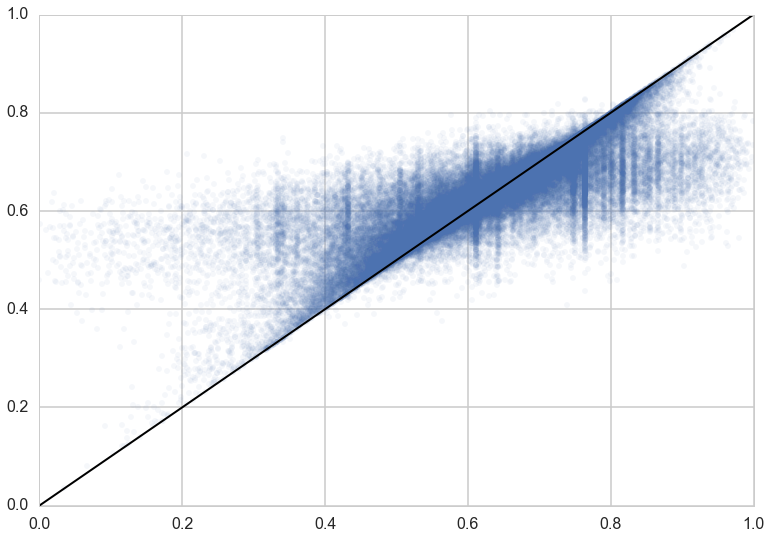

In [35]:
#your code here
plt.plot(c0df_eb['mean'], c0df_eb['thetas'], '.', alpha=0.05);
plt.plot([0,1],[0,1], 'k-', lw=2)

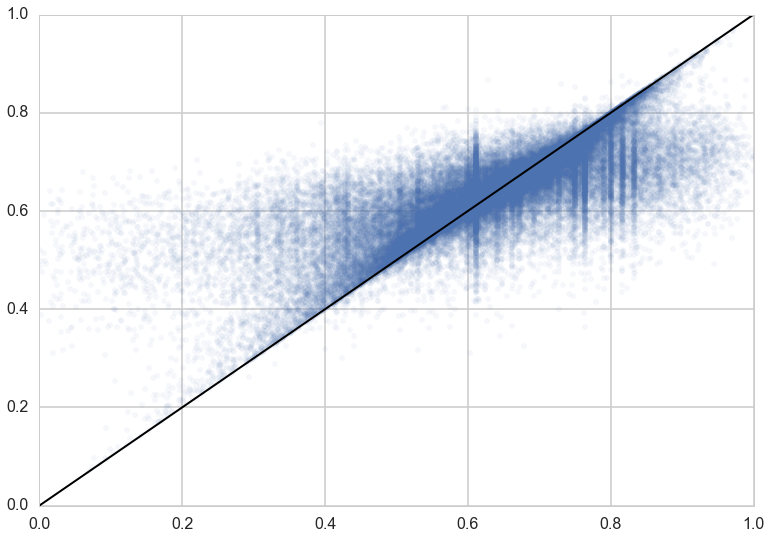

In [36]:
#your code here
plt.plot(c1df_eb['mean'], c1df_eb['thetas'], '.', alpha=0.05);
plt.plot([0,1],[0,1], 'k-', lw=2)

*your answer here*

There are some clear indicators of shrinkage here, the x-axis gives us the original probabilities while the y-axis gives us the shrunken probabilities $\theta_i$. The range of vales in x tend to span the entire range between 0 and 1 while $\theta$s tend to range between 0.2 and 0.8. There are also values that are very much near the line which indicates no shrinkage at all, this could be due to a large number of sentences in the review, hence there is less need to pool information across other reviews. 

#### Shrinkage plots on individual probabilities

We'll use our old friend the restaurant `T2zItRCqolfzSZR2Io0OZg` and its probabilities to illustrate shrinkage. Below we provide code to make a plot of probabilities. The unshrunk probabilities are put at y=0 with some jitter. The shrunk ones are at y=1. This will make a classic shrinkage plot like in the textbooks. 

Variances of 0 due to there being only 1 sample are rescaled to being 4 since that shows huge uncertainty.

In [37]:
import itertools
def shrinkage_plot(data):
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me2, te2, c in data:
            color=next(palette)
            noise=0.04*np.random.randn()
            noise2=0.04*np.random.randn()
            plt.plot([m,t],[noise,1+noise2],'o-', color=color, lw=1)
            if me2==0:
                me2=4
            plt.errorbar([m,t],[noise,1+noise2], xerr=[np.sqrt(me2), np.sqrt(te2)], color=color,  lw=1)
        plt.yticks([])
        plt.xlim([0,1])
        sns.despine(offset=-2, trim=True, left=True)
    return plt.gca()

Here is the dataframe with EB estimates for this restaurant from topic 0:

In [38]:
test0=c0df_eb[c0df_eb['rid']=='T2zItRCqolfzSZR2Io0OZg']
test0

,review_id,rid,count,mu,tau2,mean,var,thetas,varthetas
8,--3QRshg8GhfimzyGWkcAQ,T2zItRCqolfzSZR2Io0OZg,2,0.750688,0.002817,0.756603,0.000011,0.756592,0.000005
19430,7Mg3i3KvbFF5eSoRYoc48w,T2zItRCqolfzSZR2Io0OZg,1,0.750688,0.002817,0.751882,0.000000,0.750688,0.002817
64615,QxEQ5q7R0SWGL31niiETyg,T2zItRCqolfzSZR2Io0OZg,6,0.750688,0.002817,0.667189,0.005438,0.687514,0.000686
77013,WNDMIxVnfMI7wq7Lc9mi4Q,T2zItRCqolfzSZR2Io0OZg,2,0.750688,0.002817,0.837516,0.002978,0.807488,0.000974
94050,cmSaTa-eyoEAUSGThp5A4g,T2zItRCqolfzSZR2Io0OZg,3,0.750688,0.002817,0.687485,0.017147,0.729822,0.001887
134516,uBLMbE-Pa0IFx-xghripIQ,T2zItRCqolfzSZR2Io0OZg,2,0.750688,0.002817,0.630500,0.064716,0.741063,0.002591
141202,x72wx4MCuUV_-St6q2eROg,T2zItRCqolfzSZR2Io0OZg,3,0.750688,0.002817,0.801496,0.005973,0.780457,0.001167


And here is how we produce the plot. We zip together the data from the shrunk dataframe, the first 2 element being the unshrunk and shrunk probability estimates, and the second their variances. The final element is the counts. This data is passed to `shrinkage_plot`. Notice that the variance here is divided by the count for us.

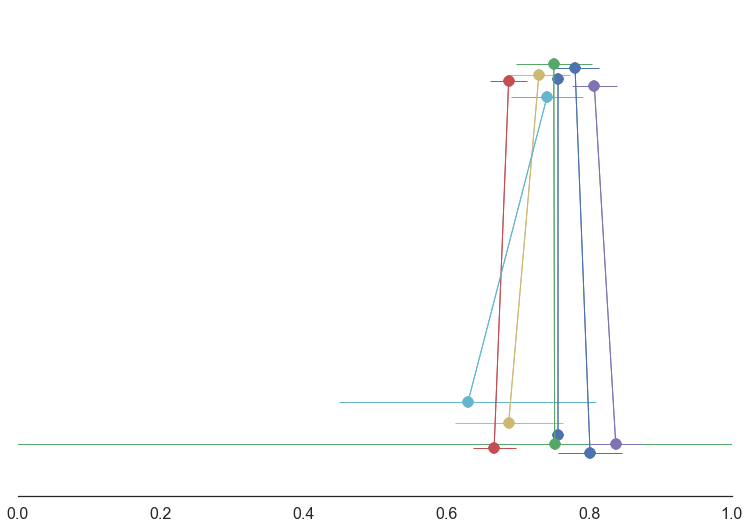

In [39]:
data=zip(test0['mean'], test0['thetas'], test0['var']/test0['count'], test0['varthetas'], test0['count'])
shrinkage_plot(data);

Similarly, lets find our restaurant in the topic 1 dataframe:

In [40]:
test1=c1df_eb[c1df_eb['rid']=='T2zItRCqolfzSZR2Io0OZg']
test1

,review_id,rid,count,mu,tau2,mean,var,thetas,varthetas
9,--3QRshg8GhfimzyGWkcAQ,T2zItRCqolfzSZR2Io0OZg,1,0.728207,0.016908,0.888077,0.000000,0.728207,0.016908
19431,7Mg3i3KvbFF5eSoRYoc48w,T2zItRCqolfzSZR2Io0OZg,4,0.728207,0.016908,0.567850,0.041787,0.629090,0.006457
26393,AO3QETuRVA_e5Nn6VFOKUQ,T2zItRCqolfzSZR2Io0OZg,2,0.728207,0.016908,0.626272,0.000012,0.626310,0.000006
64616,QxEQ5q7R0SWGL31niiETyg,T2zItRCqolfzSZR2Io0OZg,5,0.728207,0.016908,0.626948,0.001345,0.628534,0.000265
94051,cmSaTa-eyoEAUSGThp5A4g,T2zItRCqolfzSZR2Io0OZg,2,0.728207,0.016908,0.838555,0.000082,0.838287,0.000041
141203,x72wx4MCuUV_-St6q2eROg,T2zItRCqolfzSZR2Io0OZg,1,0.728207,0.016908,0.758943,0.000000,0.728207,0.016908


#### 5.5 Extract data into the variable `data2` and make a shrinkage plot for Topic 1.

This is for the business `T2zItRCqolfzSZR2Io0OZg` for whom we extracted a dataframe `test1` above. Extract analogous data `data2` from `test1` and make a similar shrinkage plot. Compare and contrast the two plots.

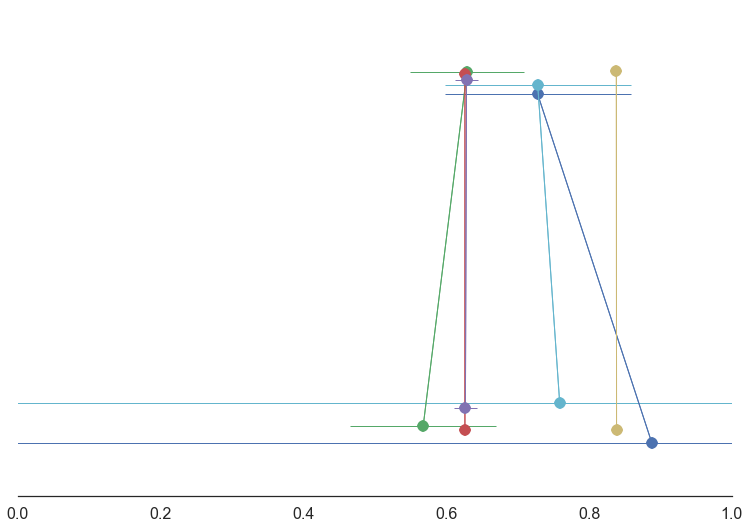

In [41]:
data2=zip(test1['mean'], test1['thetas'], test1['var']/test1['count'], test1['varthetas'], test1['count'])
shrinkage_plot(data2);

*your answer here*

Shrinkage is fairly evident from this plot in two ways, the average values (dots) tend to be closer to one another as you move from standard (bottom) to shrunk (top). Furthermore after shrinking we can get better estimates of the standard error, hence the error bars are much smaller.

#### 5.6 Create probability shrinkage plots.

Using the `prob` function you defined earlier, we can calculate the decision probabilities to decide whether a review is bullish on topic 0 or on topic one. We'll make a plot to show how these probabilities change on shrinking. Write a function `prob_shrinkage_plot` to implement this plot. 

Write similar code to `shrinkage_plot`, but this time, on the y-axis plot the probabilities calculated using `prob` on the unshrunk model instead of the y=0 we did in `shrinkage_plot`. Remember to to divide the within review variance by the count.  

And instead of y=1, use probabilities calculated using the shrunk model. You can use a count of 1 in `prob` since the posterior variance estimate already takes this into account.

Jitter if necessary.

Dont forget to plot the standard-deviation error-bar on the x-axis as before. The argument into this function is `data`, and it has the same form as the `data` in `shrinkage_plot`.

The signature is, ofcourse:

`def prob_shrinkage_plot(data):`.

Comment and compare the results below.

In [42]:
#your code here
def prob_shrinkage_plot(data):
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me2, te2, c in data:
            color=next(palette)
            noise=0.001*np.random.randn()
            noise2=0.001*np.random.randn()
            if me2==0:
                me2=4
            p = prob(m,me2, 1.)
            peb=prob(t, te2, 1.)
            plt.plot([m,t],[p,peb],'o-', color=color, lw=1)
            
            plt.errorbar([m,t],[p+noise,peb+noise2], xerr=[np.sqrt(me2), np.sqrt(te2)], color=color,  lw=1)
        ax=plt.gca()
        plt.xlim([0,1])
        plt.ylim([0, 1.05])
    return ax

The plots are called in the same way as `shrinkage_plot`:

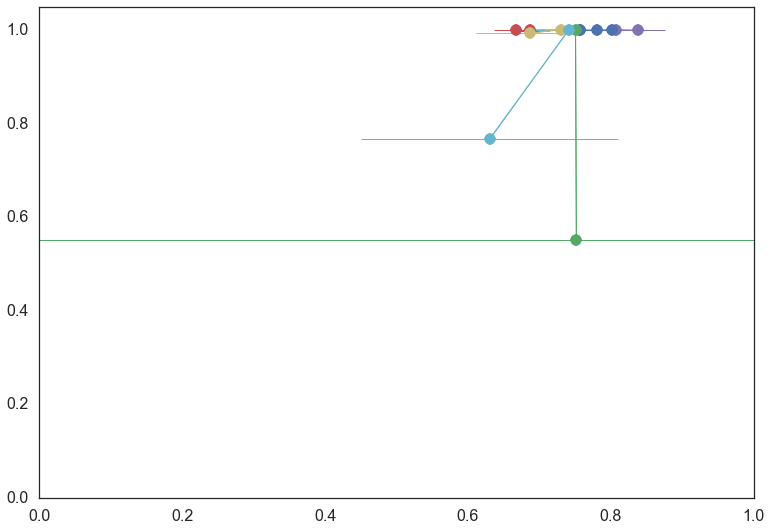

In [43]:
prob_shrinkage_plot(data);

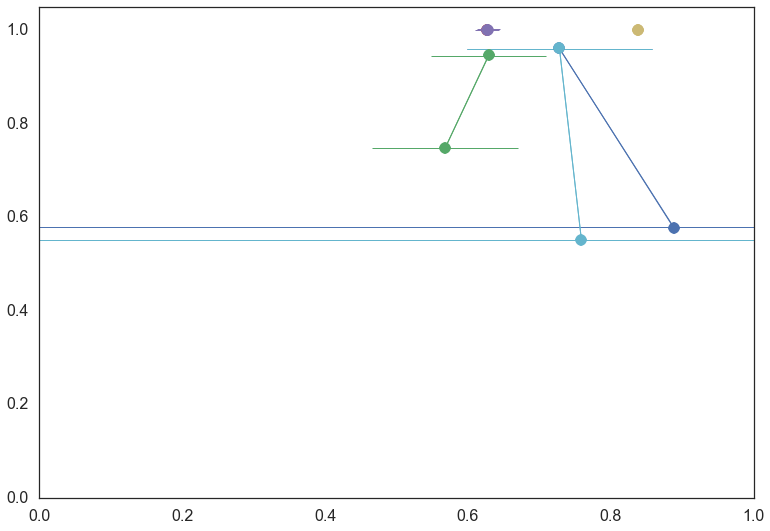

In [44]:
prob_shrinkage_plot(data2);

*your answer here*

A similar trend to the previous section can be seen here, the average values (dots) tend to be closer to one another as you move from standard (bottom) to shrunk (top). Furthermore after shrinking we can get better estimates of the standard error, hence the error bars are much smaller. There also does not seem to be a difference between the two different classes. Again looking at more examples would be interesting to do, but we don't here for conciseness. 

#### 5.7 How would one evaluate these probabilities?

Remember that LDA is an unsupervised algorithm in answering this question.

*your answer here*

A few things worth noting here. LDA is an unsupervised algorithm, it does not have true labels, we interpreted what these two groups might mean. This makes things a little bit difficult in terms of interpreting these probabilities. For example, what if we looked at three clusters instead of two? Would we have a 'better' fit somehow? These things are very subjective. 

But even after all this subjectivity, we do have some measure of positivity about both food and place that we can be confident about with some certainty. This is actually a huge accomplishment! So, each restaurant and review could be tagged as "reviews say the food is good" (similarly for place). As a frequent Yelp user, I'd love some summary of what reviewers tend to be saying. 

**FIN!**